In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#metrics setting
g_loss_metrics = tf.metrics.Mean(name = 'g_loss')
d_loss_metrics = tf.metrics.Mean(name = 'd_loss')
total_loss_metrics = tf.metrics.Mean(name = 'total_loss')

In [3]:
#hyper_parameters
ITERATION = 10000
Z_DIM = 100
BATCH_SIZE = 512
BUFFER_SIZE = 60000
D_LR = 0.0004
G_LR = 0.0004
IMAGE_SHAPE = (28,28,1)
RANDOM_SEED = 42

In [4]:
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [5]:
test_n = tf.random.normal([16,Z_DIM])
test_u = tf.random.uniform([16,Z_DIM])

In [6]:
def get_random_z(batch_size,z_dim):
    return tf.random.uniform([batch_size,z_dim],minval=-1,maxval=1)

In [7]:
#define discriminator
def make_discriminator(input_shape):
    return tf.keras.Sequential([
        layers.Conv2D(64,5,strides=2,padding='same',input_shape = input_shape),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        
        layers.Conv2D(128,5,strides=2,padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        
        layers.Flatten(),
        layers.Dense(1)
    ])

In [8]:
D = make_discriminator(IMAGE_SHAPE)

In [9]:
#define generator
def make_generator(input_shape):
    return tf.keras.Sequential([
        layers.Dense(7*7*256,use_bias=False,input_shape = input_shape),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        layers.Reshape((7,7,256)),
        
        layers.Conv2DTranspose(128,5,strides=1,padding='same',use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        layers.Conv2DTranspose(64,5,strides=2,padding='same',use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        layers.Conv2DTranspose(1,5,strides=2,padding='same',use_bias=False,activation='tanh')
        
    ])

In [10]:
G = make_generator((Z_DIM,))

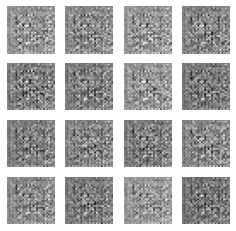

In [11]:
#defing generator visualization functions
def generator_plot_image(generator_model,test_noise):
    pre_images = generator_model(test_noise,training=False)
    #因为定义了噪声的大小为16*100
    fig = plt.figure(figsize=(4,4))
    for i in range(pre_images.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow((pre_images[i] +1)/2,cmap='gray')
        plt.axis('off')
    plt.show()
generator_plot_image(G,test_u)

In [12]:
D(G(test_u,training=False))

<tf.Tensor: shape=(16, 1), dtype=float32, numpy=
array([[ 5.1858980e-04],
       [-3.8313970e-04],
       [-5.0837244e-04],
       [-1.1002767e-04],
       [-6.1450148e-05],
       [-1.0095353e-03],
       [-6.6324422e-04],
       [-8.8210701e-04],
       [-4.1031520e-04],
       [-6.8533956e-04],
       [ 1.9882165e-05],
       [-1.7721830e-03],
       [-1.5949332e-03],
       [-2.6592059e-04],
       [-5.7419081e-04],
       [-4.8595635e-04]], dtype=float32)>

In [13]:
#Wasserstein Loss
def get_loss_fn():
    def d_loss_fn(real_logits,fake_logits):
        return tf.reduce_mean(fake_logits)-tf.reduce_mean(real_logits)
    def g_loss_fn(fake_logits):
        return -tf.reduce_mean(fake_logits)
    return d_loss_fn,g_loss_fn

In [30]:
#data load & preprocessing
(train_x,_),(_,_) = tf.keras.datasets.fashion_mnist.load_data()
train_x = train_x[...,tf.newaxis].astype("float32")
train_x = (train_x - 127.5) / 127.5
train_ds = (
    tf.data.Dataset.from_tensor_slices(train_x)
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE,drop_remainder = True)
    .repeat()
)

train_ds_1 = (
    tf.data.Dataset.from_tensor_slices(train_x)
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE,drop_remainder = True)
)

In [15]:
#optimizer
g_optim = tf.keras.optimizers.Adam(G_LR,beta_1 = 0.5,beta_2 = 0.999)
d_optim = tf.keras.optimizers.Adam(D_LR,beta_1 = 0.5,beta_2 = 0.999)

In [16]:
#loss function
d_loss_fn,g_loss_fn = get_loss_fn()

In [17]:
@tf.function
def train_step(real_images):
    z = get_random_z(BATCH_SIZE,Z_DIM)
    with tf.GradientTape() as d_tape,tf.GradientTape() as g_tape:
        fake_images = G(z,training=True)
        
        fake_logits = D(fake_images,training = True)
        real_logits = D(real_images,training = True)
        
        d_loss = d_loss_fn(real_logits,fake_logits)
        g_loss = g_loss_fn(fake_logits)
        
    d_gradients = d_tape.gradient(d_loss,D.trainable_variables)   
    g_gradients = g_tape.gradient(g_loss,G.trainable_variables)
    
    d_optim.apply_gradients(zip(d_gradients,D.trainable_variables))
    g_optim.apply_gradients(zip(g_gradients,G.trainable_variables))
    
    return g_loss,d_loss

In [18]:
#training loop
def train(ds,log_freq = 500):
    ds  = iter(ds)
    for step in range(ITERATION):
        images = next(ds)
        g_loss,d_loss = train_step(images)
        
        g_loss_metrics(g_loss)
        d_loss_metrics(d_loss)
        total_loss_metrics(g_loss + d_loss)
        if step % log_freq == 0:
            template = '[{}/{}] D_loss ={:.5f} G_loss ={:.5f} Total_loss={:.5f}' 
            print(template.format(step,ITERATION,d_loss_metrics.result(),
                                 g_loss_metrics.result(),total_loss_metrics.result()))
            g_loss_metrics.reset_states()
            d_loss_metrics.reset_states()
            total_loss_metrics.reset_states()
            generator_plot_image(G,test_u)
            

In [32]:
#training loop
def train_1(ds,epochs):
    for epoch in range(epochs):
        for image_batch in ds:
            g_loss,d_loss = train_step(image_batch)

        g_loss_metrics(g_loss)
        d_loss_metrics(d_loss)
        total_loss_metrics(g_loss + d_loss)
        
        template = '[{}/{}] D_loss ={:.5f} G_loss ={:.5f} Total_loss={:.5f}' 
        print(template.format(epoch,epochs,d_loss_metrics.result(),
                             g_loss_metrics.result(),total_loss_metrics.result()))
        g_loss_metrics.reset_states()
        d_loss_metrics.reset_states()
        total_loss_metrics.reset_states()
        generator_plot_image(G,test_u)


[0/5] D_loss =2.94279 G_loss =77.34613 Total_loss=80.28893


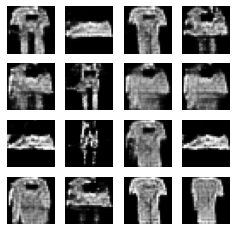

[1/5] D_loss =0.42726 G_loss =243.54654 Total_loss=243.97380


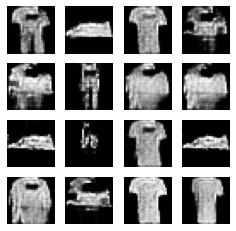

[2/5] D_loss =-72.81100 G_loss =232.84952 Total_loss=160.03851


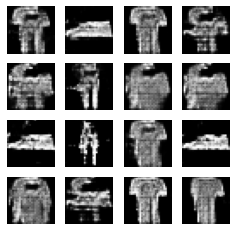

[3/5] D_loss =-18.26672 G_loss =64.94807 Total_loss=46.68135


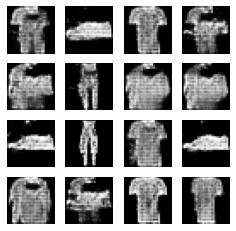

[4/5] D_loss =11.10083 G_loss =263.33563 Total_loss=274.43646


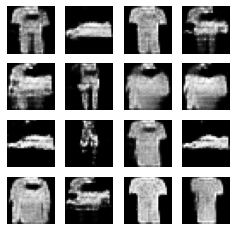

In [34]:
train_1(train_ds_1,5)

In [35]:
#train(train_ds)

SyntaxError: invalid syntax (<ipython-input-35-9f72208eea79>, line 1)